In [1]:
import pandas as pd
import numpy as np

# 그래프 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

# 회귀 라이브러리
import statsmodels.api as sm
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, r2_score
import pickle
# xai 라이브러리
import shap

# 워닝 무시
import warnings
warnings.filterwarnings('ignore')

### 1. 데이터 불러오기 & 정보 

In [4]:
strDataPath = 'D:/Works/Data/MLTraining/Battery_RUL.csv'
df=pd.read_csv(strDataPath)
print(df.shape)
df.head(3)

(15064, 9)


,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.4885,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.5125,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.9920,4.249,3.224,5508.993,6762.02,10420.38,1110


In [5]:
# 변수 형식 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15064 entries, 0 to 15063
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cycle_Index                15064 non-null  float64
 1   Discharge Time (s)         15064 non-null  float64
 2   Decrement 3.6-3.4V (s)     15064 non-null  float64
 3   Max. Voltage Dischar. (V)  15064 non-null  float64
 4   Min. Voltage Charg. (V)    15064 non-null  float64
 5   Time at 4.15V (s)          15064 non-null  float64
 6   Time constant current (s)  15064 non-null  float64
 7   Charging time (s)          15064 non-null  float64
 8   RUL                        15064 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.0 MB


In [6]:
# 데이터 요약 정보
df.describe()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
count,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000
mean,556.155005,4581.273960,1239.784672,3.908176,3.577904,3768.336171,5461.266970,10066.496204,554.194172
std,322.378480,33144.012077,15039.589269,0.091003,0.123695,9129.552477,25155.845202,26415.354121,322.434514
min,1.000000,8.690000,-397645.908000,3.043000,3.022000,-113.584000,5.980000,5.980000,0.000000
25%,271.000000,1169.310000,319.600000,3.846000,3.488000,1828.884179,2564.310000,7841.922500,277.000000
50%,560.000000,1557.250000,439.239471,3.906000,3.574000,2930.203500,3824.260000,8320.415000,551.000000
75%,833.000000,1908.000000,600.000000,3.972000,3.663000,4088.326500,5012.350000,8763.282500,839.000000
max,1134.000000,958320.370000,406703.768000,4.363000,4.379000,245101.117000,880728.100000,880728.100000,1133.000000


In [7]:
#Cycle_Index	: 배터리 충방전 몇회 진행되었는지
#Discharge Time (s)	: 방전 소요 시간
#Decrement 3.6-3.4V (s)	: 전압 강하 소요 시간
#Max. Voltage Dischar. (V) : 최대 방전 전압
#Min. Voltage Charg. (V) : 최소 충전 전압
#Time at 4.15V (s) : 4.15 V 도달 시간
#Time constant current (s) : CC 충전 시간
#Charging time (s) : 총 충전 시간
#RUL : 배터리 수명 지표

### 2. 데이터 시각화

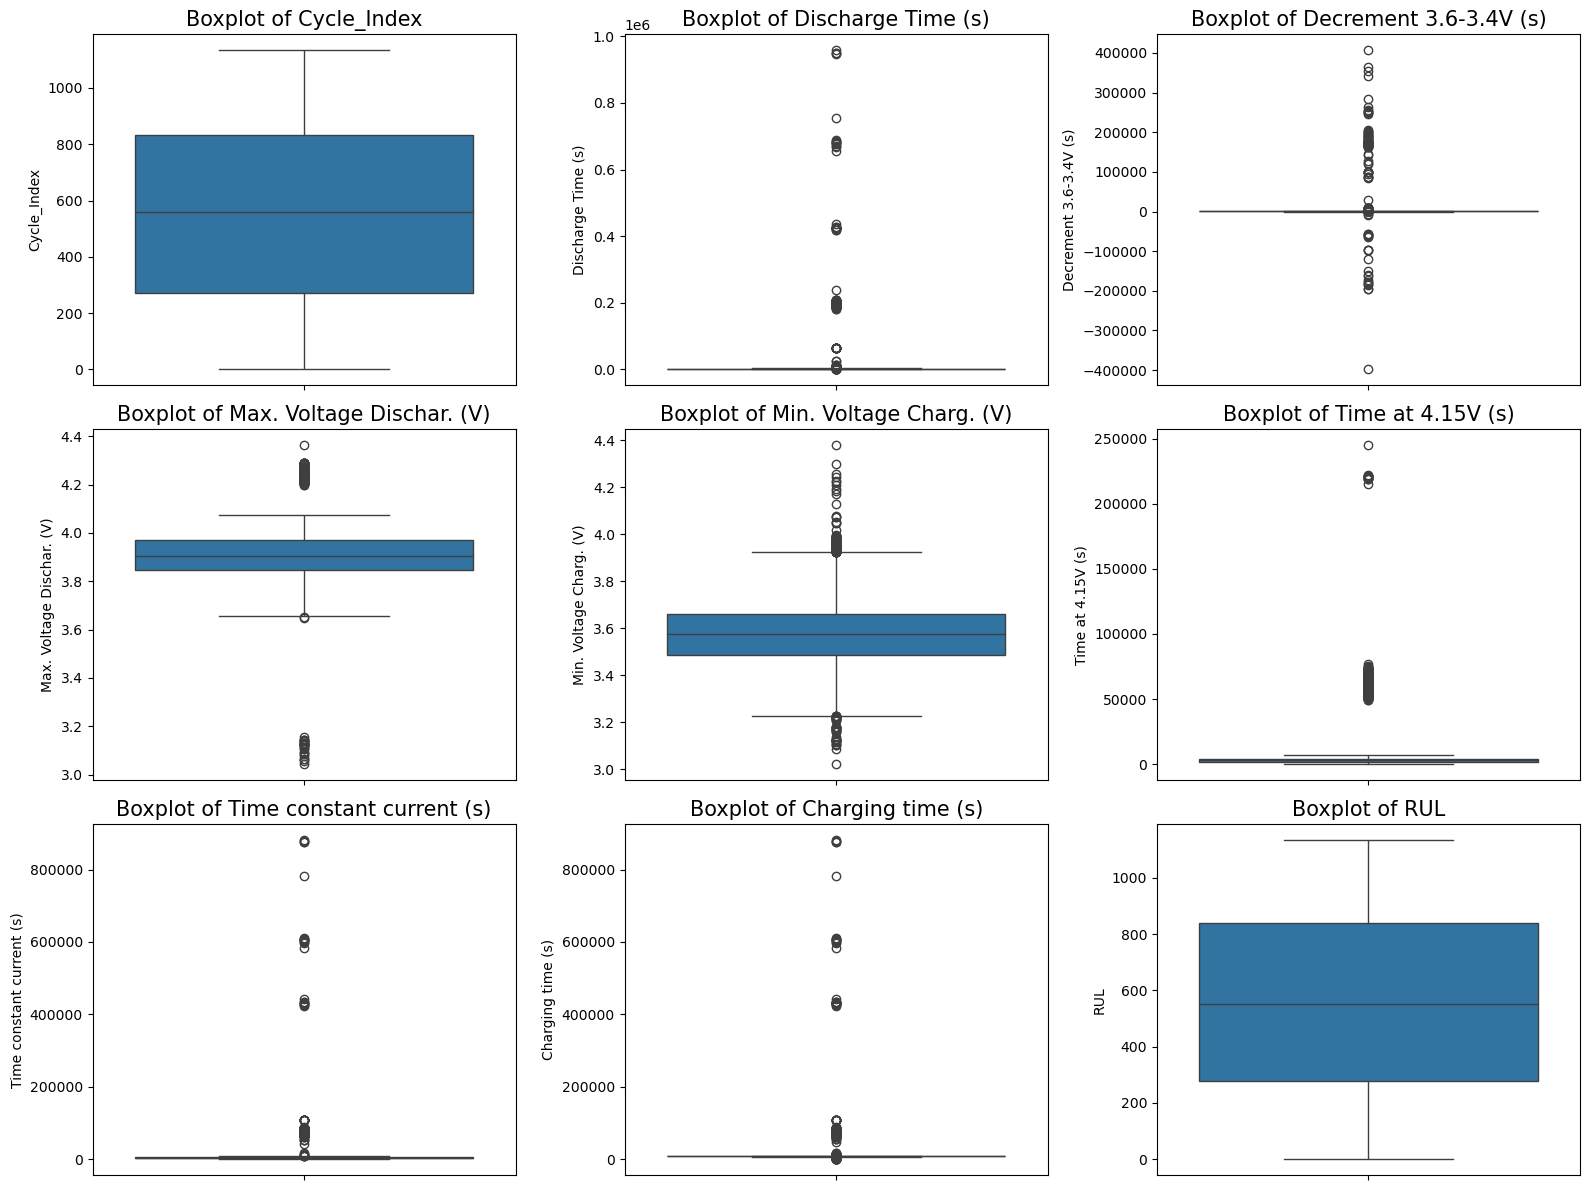

In [8]:
# 모든 변수들의 boxplot 그려보기
plt.figure(figsize=(16, 12))

# Plot boxplots for each numerical column
for i, col in enumerate(list(df.columns), start=1):
    plt.subplot(3, 3, i)
    sns.boxplot(y = df[col])
    plt.title(f'Boxplot of {col}', fontdict={'fontsize':15})
plt.tight_layout()

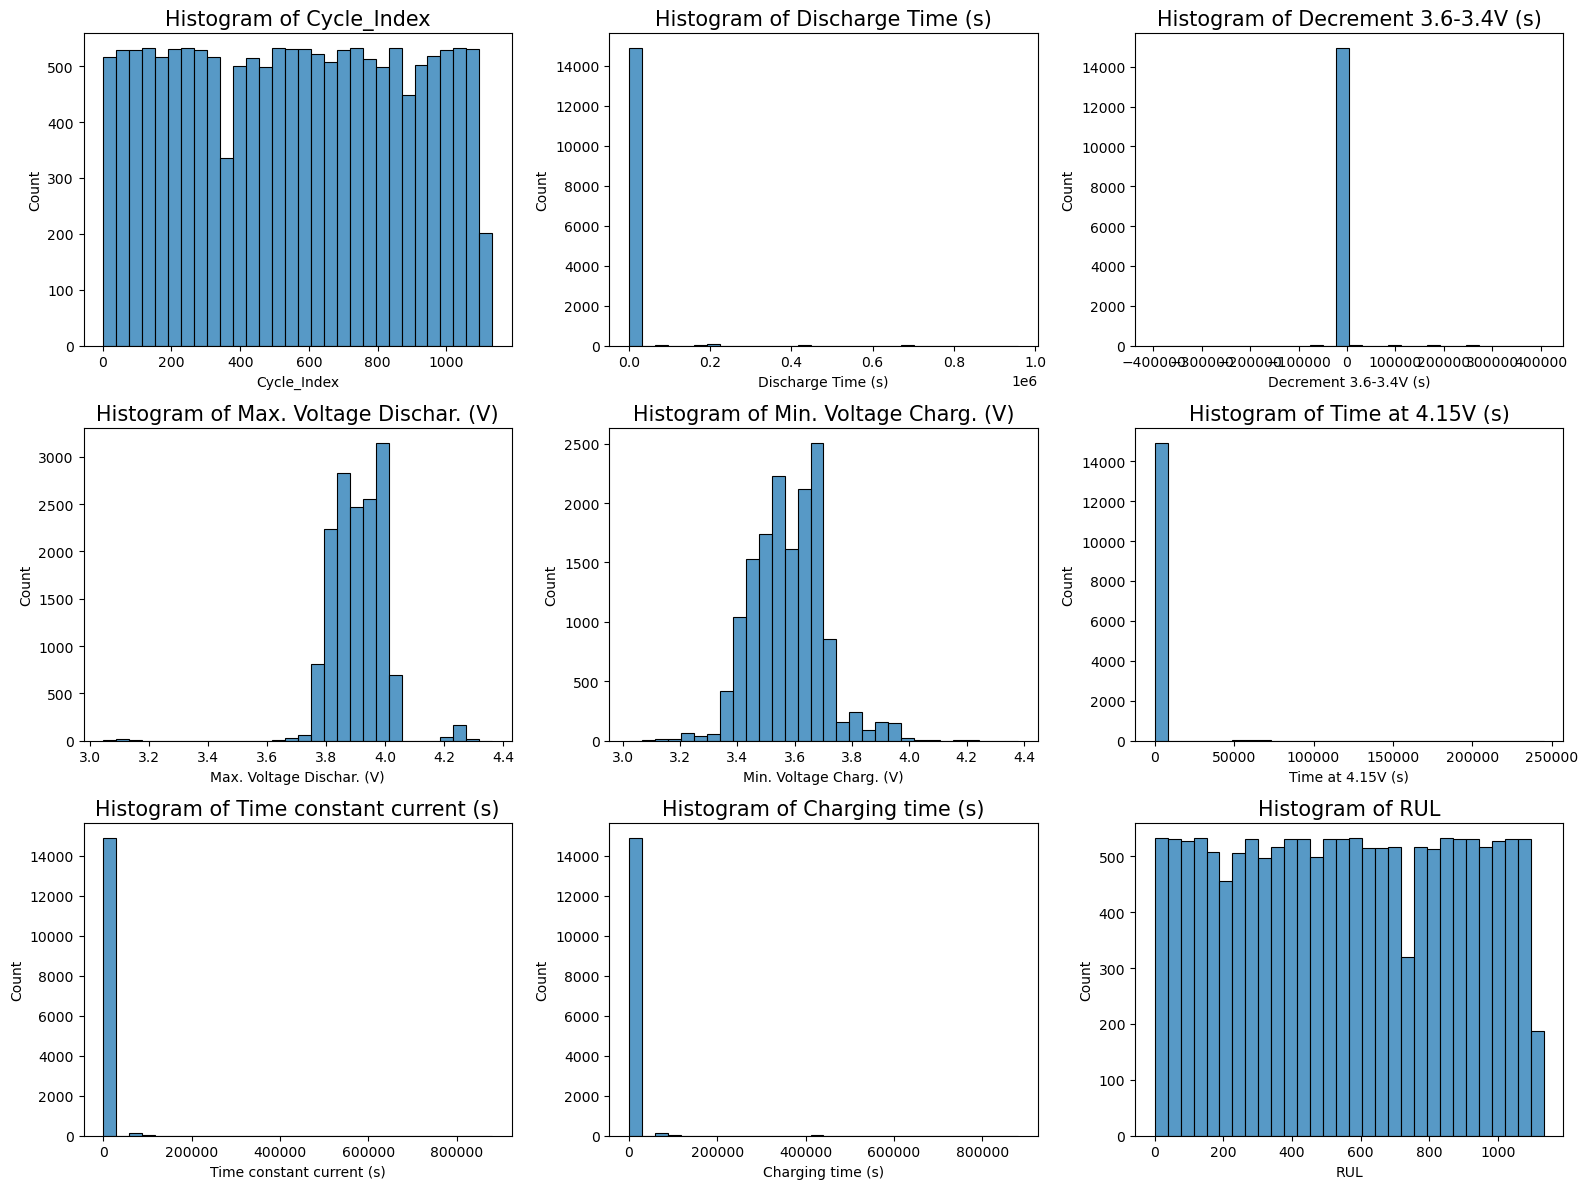

In [9]:
# 모든 변수들의 histogram 그려보기
plt.figure(figsize=(16, 12))

# Plot boxplots for each numerical column
for i, col in enumerate(list(df.columns), start=1):
    plt.subplot(3, 3, i)
    sns.histplot(x = df[col],bins=30) #kde = True
    plt.title(f'Histogram of {col}', fontdict={'fontsize':15});
plt.tight_layout()

### Trend Chart

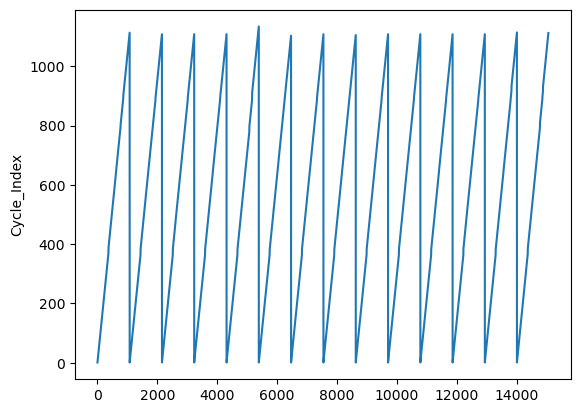

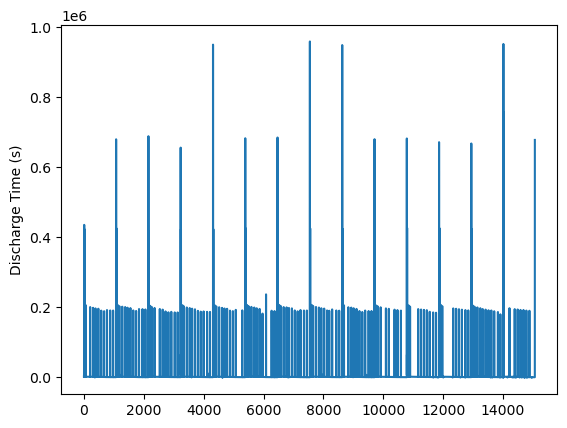

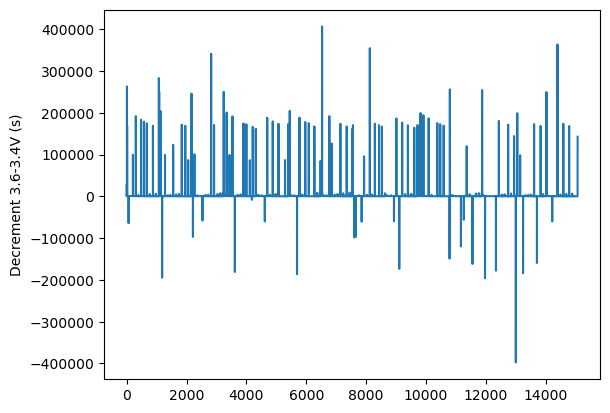

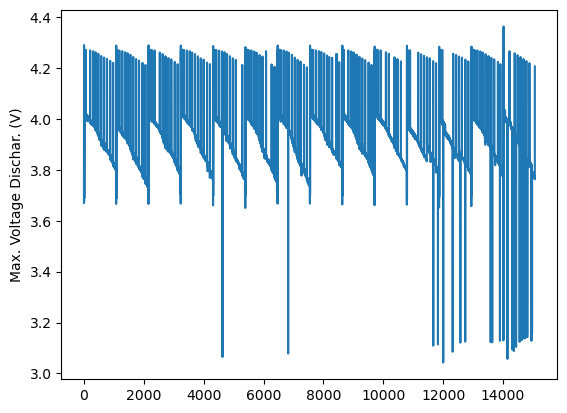

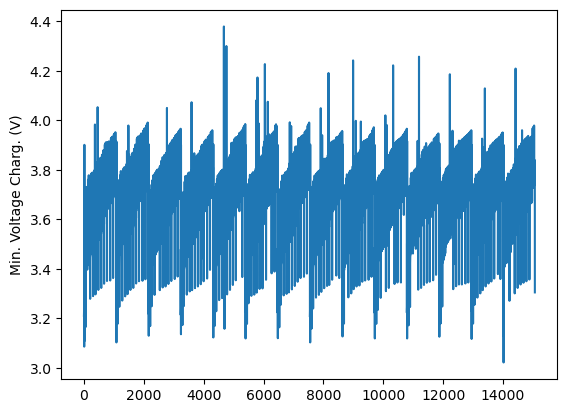

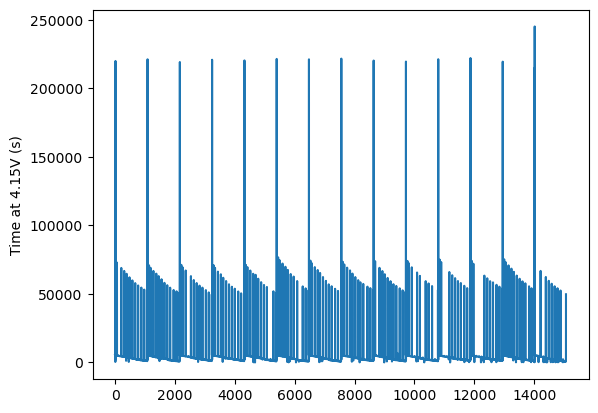

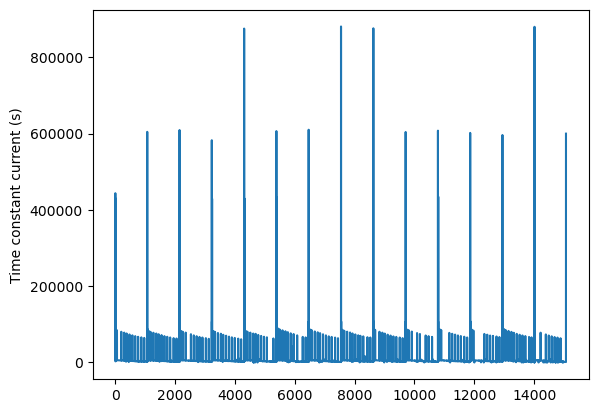

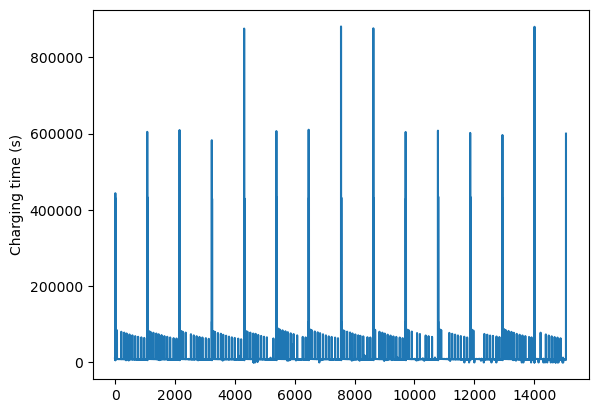

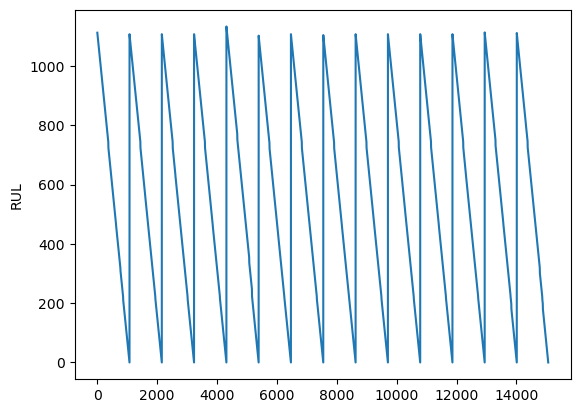

In [10]:
for i in range(len(df.columns)):
    plt.plot(df[df.columns[i]])
    plt.ylabel(df.columns[i])
    plt.show()

### Correlation Analysis

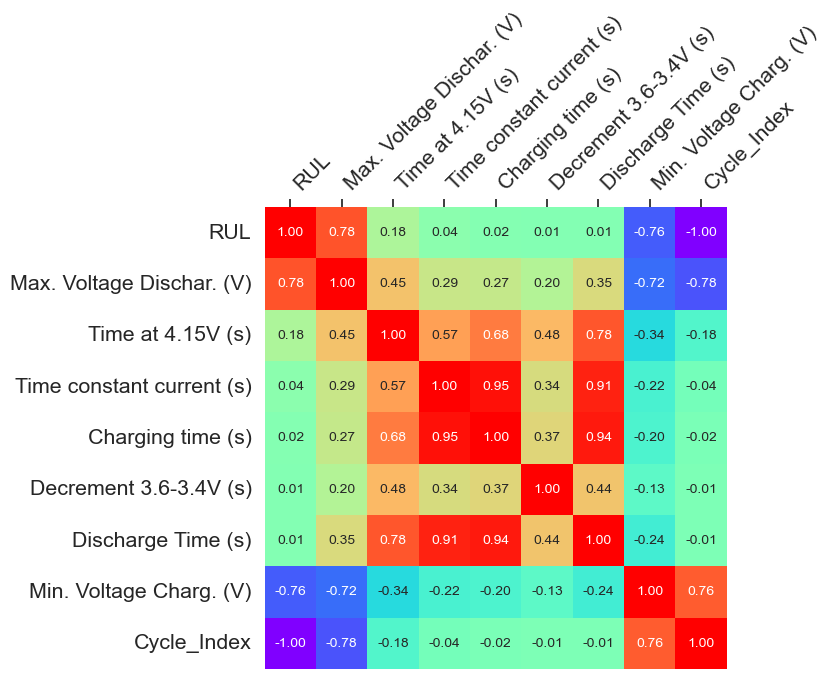

In [11]:
# correlation

corrmat = df.corr()
plt.figure(figsize=(6, 6))
k=9
cols = corrmat.nlargest(k, 'RUL')['RUL'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.4)
hm = sns.heatmap(cm, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values,cmap="rainbow")
hm.xaxis.tick_top()
plt.xticks(rotation=45, ha='left')
plt.show()

## 3. Data Preprocessing

In [12]:
# numeric, categorical value 분리
numeric_list = []
categorical_list = []

for i in df.columns:
#     print(i)
    if df[i].dtypes == 'O':  # 범주형 변수
        categorical_list.append(i)
    else:  # 수치형 변수
        numeric_list.append(i)
        
print(numeric_list)
print(categorical_list)

['Cycle_Index', 'Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Max. Voltage Dischar. (V)', 'Min. Voltage Charg. (V)', 'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)', 'RUL']
[]


### 3.1 이상치 제거

In [14]:
# 이상치 제거 - IQR

def remove_outliers_iqr(df,column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3-q1
    lower_bound = q1 - 1.5*IQR
    upper_bound = q3 + 1.5*IQR
    
    df_iqr = df[(df[column]>=lower_bound) & (df[column]<=upper_bound)]
    return df_iqr

df = remove_outliers_iqr(df, 'Discharge Time (s)')
df

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
15,17.0,2261.34,883.200000,4.038,3.901,1949.664,2922.69,6070.11,1096
16,18.0,2259.46,883.199000,4.042,3.373,5181.377,6161.38,9310.98,1095
17,19.0,2256.61,878.400000,4.042,3.374,5181.375,6154.37,9296.64,1094
18,20.0,2252.83,873.601000,4.043,3.374,5174.334,6147.33,9243.58,1093
...,...,...,...,...,...,...,...,...,...
15058,1107.0,773.00,180.480000,3.774,3.742,922.712,1412.31,6659.62,5
15059,1108.0,770.44,179.523810,3.773,3.742,922.775,1412.38,6678.88,4
15060,1109.0,771.12,179.523810,3.773,3.744,915.512,1412.31,6670.38,3
15061,1110.0,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,2


### 3.2 DataSlice :  test set 구분 (마지막 두사이클 -> test set)

In [15]:
idxTest = df.loc[df["Cycle_Index"] == 1]["Cycle_Index"][-2:].index

In [16]:
dfTest = df.iloc[idxTest[0]:]
dfTrain = df.iloc[:idxTest[0]]

In [17]:
# X, Y 분리
XTrain = dfTrain.drop(columns=['RUL', 'Cycle_Index'])
YTrain = dfTrain['RUL']
x_test = dfTest.drop(columns=['RUL', 'Cycle_Index'])
y_test = dfTest["RUL"]

In [18]:
YTrain.shape

(12941,)

In [19]:
y_test.shape

(1801,)

## 3.3 Scaling

In [20]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(XTrain)
# XTrain_scaled = scaler.transform(XTrain)
# XTest_scaled = scaler.transform(x_test)
# XTrain = XTrain
# x_test = x_Test_scaled

In [21]:
x_train, x_valid, y_train, y_valid = train_test_split(XTrain, YTrain, 
                                                    test_size=0.2, random_state=111)
x_train.head(3)

,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s)
9581,956.06,255.6245,3.808,3.810,1015.312,1757.00,8296.06
8162,1524.00,447.0000,3.907,3.564,2858.344,3716.34,8180.34
6444,826.62,198.9600,3.760,3.721,1045.175,1556.38,7940.69


In [22]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

(10352, 7)
(10352,)
(2589, 7)
(2589,)
(1801, 7)
(1801,)


### 4. Model Training

#### 4.1 XGBoost

In [37]:
xgb_model = XGBRegressor(n_estimators=100, 
                        max_depth=10, 
                        learning_rate=0.1, 
                        subsample=0.7, 
                        random_state=42)

In [38]:
# 모델 학습
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [39]:
# 예측
# 예측은 학습에 사용된 Data와 Test Data 모두 예측하고 평가함(※ 과적합 여부 판별)
y_pred_train = xgb_model.predict(x_train)
y_pred_valid = xgb_model.predict(x_valid)
y_pred_test = xgb_model.predict(x_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
print('mae_train(mae): ', mae_train)
r2_train = r2_score(y_train, y_pred_train)
print('r2_score(r2): ', r2_train)
print('')

mae_valid = mean_absolute_error(y_valid, y_pred_valid)
print('mae_valid(mae): ', mae_valid)
r2_valid = r2_score(y_valid, y_pred_valid)
print('r2_score(r2): ', r2_valid)
print('')

mae_test = mean_absolute_error(y_test, y_pred_test)
print('mae_test(mae): ', mae_test)
r2_test = r2_score(y_test, y_pred_test)
print('r2_score(r2): ', r2_test)
#mae는 낮을수록 좋고, r2는 1에 가까울수록좋음

mae_train(mae):  3.5167892117749964
r2_score(r2):  0.999743592142607

mae_valid(mae):  8.387428553880712
r2_score(r2):  0.9974905983118696

mae_test(mae):  62.452602015509335
r2_score(r2):  0.9263885440981026


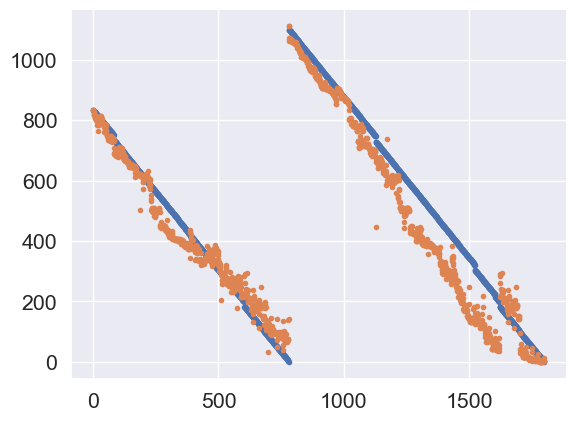

In [41]:
plt.plot(y_test.values, '.')
plt.plot(y_pred_test, '.')

In [42]:
# 테스트 데이터로 예측값과 실제값 비교 
result = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred_test})
result['diff'] = result['Real Values'] - result['Predicted Values']
result

,Real Values,Predicted Values,diff
13218,833,834.078979,-1.078979
13219,832,833.949768,-1.949768
13220,831,825.604187,5.395813
13221,830,817.799133,12.200867
13222,829,818.835632,10.164368
...,...,...,...
15058,5,1.942230,3.057770
15059,4,1.942230,2.057770
15060,3,1.942230,1.057770
15061,2,1.942230,0.057770


In [43]:
result.sort_values(by=['diff'], ascending = False)

,Real Values,Predicted Values,diff
14373,746,446.138367,299.861633
14759,341,133.792343,207.207657
14760,340,132.835724,207.164276
14758,342,135.061829,206.938171
14762,338,131.855301,206.144699
...,...,...,...
13841,172,292.666626,-120.666626
13898,115,246.970184,-131.970184
14950,115,246.970184,-131.970184
14007,5,139.485352,-134.485352


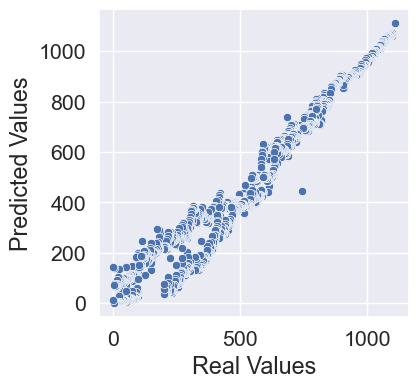

In [44]:
#테스트 데이터
sns.scatterplot(x=result['Real Values'], y=result['Predicted Values'])
plt.gcf().set_size_inches(4 ,4)

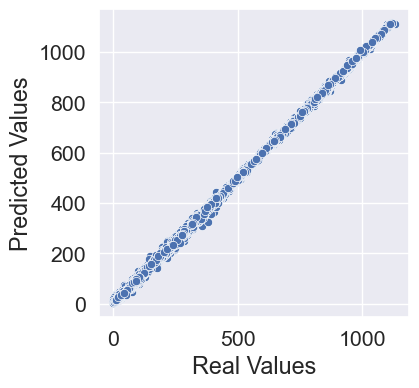

In [45]:
#학습데이터
result = pd.DataFrame({'Real Values':y_train, 'Predicted Values':y_pred_train})
sns.scatterplot(data = result, x='Real Values', y='Predicted Values')
plt.gcf().set_size_inches(4 ,4)

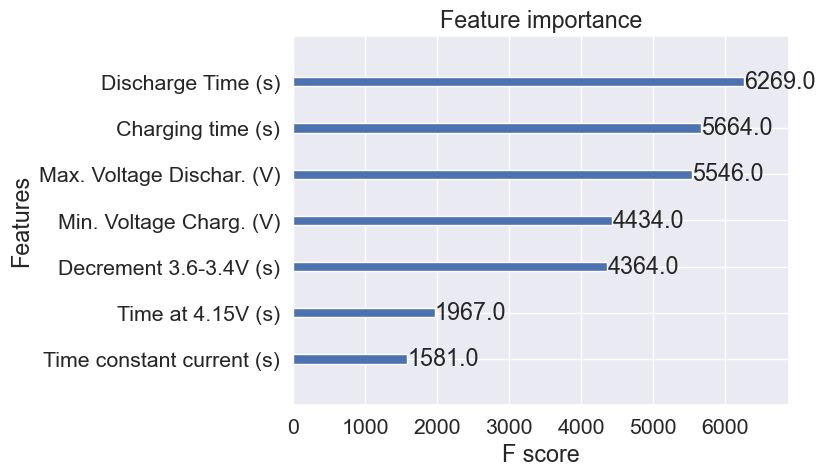

In [46]:
# 피쳐 임포턴스 확인
xgboost.plot_importance(xgb_model);

In [ ]:
### XAI

In [47]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(x_test)

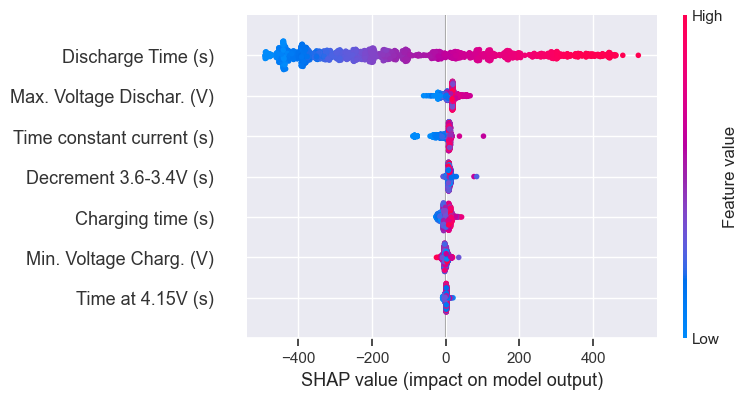

In [48]:
shap.summary_plot(shap_values, x_test)

### 4.2 Random Forest 

In [49]:
from sklearn.ensemble import RandomForestRegressor
rfr_model = RandomForestRegressor(random_state =2024)
# 모델 학습
rfr_model.fit(x_train, y_train)

RandomForestRegressor(random_state=2024)

In [51]:
# 예측
# 예측은 학습에 사용된 Data와 Test Data 모두 예측하고 평가함(※ 과적합 여부 판별)
y_pred_train = rfr_model.predict(x_train)
y_pred_valid = rfr_model.predict(x_valid)
y_pred_test = rfr_model.predict(x_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
print('mae_train(mae): ', mae_train)
r2_train = r2_score(y_train, y_pred_train)
print('r2_score(r2): ', r2_train)
print('')

mae_valid = mean_absolute_error(y_valid, y_pred_valid)
print('mae_valid(mae): ', mae_valid)
r2_valid = r2_score(y_valid, y_pred_valid)
print('r2_score(r2): ', r2_valid)
print('')

mae_test = mean_absolute_error(y_test, y_pred_test)
print('mae_test(mae): ', mae_test)
r2_test = r2_score(y_test, y_pred_test)
print('r2_score(r2): ', r2_test)
#mae는 낮을수록 좋고, r2는 1에 가까울수록좋음

mae_train(mae):  2.9371515649149917
r2_score(r2):  0.9996703009699984

mae_valid(mae):  8.15601776747779
r2_score(r2):  0.9973801918519709

mae_test(mae):  60.53882491208588
r2_score(r2):  0.929050645019756


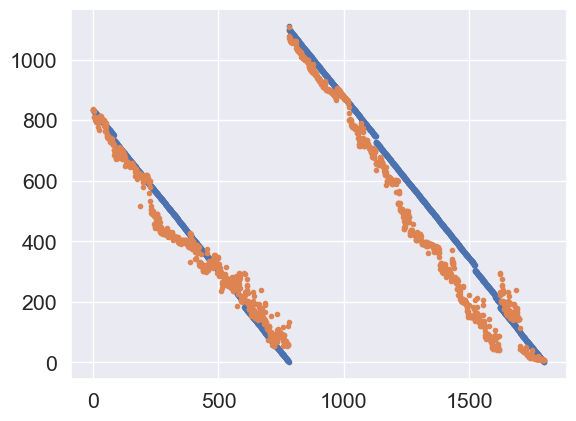

In [52]:
plt.plot(y_test.values, '.')
plt.plot(y_pred_test, '.')

Text(0.5, 0, 'Random Forest Feature Importance')

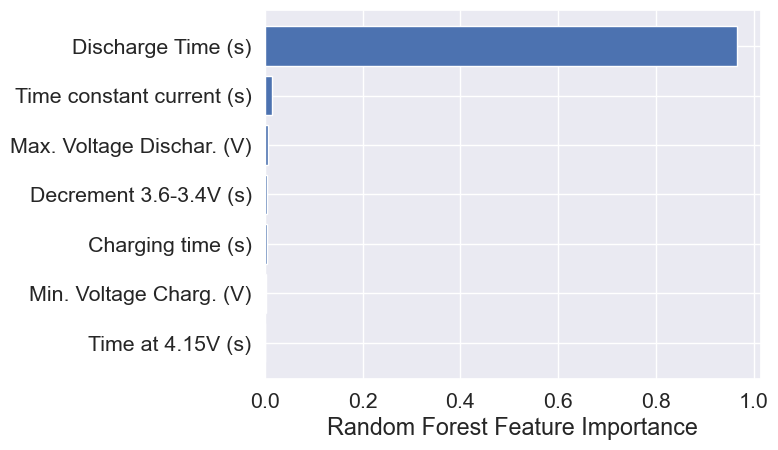

In [55]:
rfr_model.feature_importances_
sorted_idx = rfr_model.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], rfr_model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")